# Fine-tuning Ultralytics YOLO v8 Model

### Install and Import Necessary Libraries

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [9]:
from ultralytics import YOLO
import pandas as pd
import os
from shutil import copy2
import pandas as pd
import cv2
import matplotlib as plt

### Optional Cell if Using Google Colab and Drive Together

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
print('ehlo')

ehlo


## Load Pretrained Model

In [7]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 75.4MB/s]


## Data Preparation and Conversion from format when Synthetically Generating Data

In [ ]:
multiDoodDf = pd.read_csv('/content/drive/MyDrive/Capstone/multipleDoodles/resnet_df_yflipped.csv')
multiDoodDf.tail()

,image_path,word,box
19995,image_10005.png,"[1, 2, 5, 5, 8]","[[76, 347, 206, 476], [364, 38, 450, 124], [33..."
19996,image_10006.png,"[1, 2, 11, 9]","[[64, 40, 156, 132], [159, 273, 252, 366], [2,..."
19997,image_10007.png,[1],"[[39, 106, 175, 242]]"
19998,image_10008.png,"[1, 2, 11, 6, 3]","[[161, 425, 255, 519], [367, 14, 471, 118], [2..."
19999,image_10009.png,"[1, 3, 9, 10, 5]","[[1, 434, 118, 551], [170, 443, 276, 550], [29..."


In [ ]:
base_dir = '/content/drive/MyDrive/Capstone/yolo_dataset'
os.makedirs(f'{base_dir}/images/train', exist_ok=True)
os.makedirs(f'{base_dir}/labels/train', exist_ok=True)

In [ ]:
def convert_bbox(x1, y1, x2, y2, img_w, img_h):
    # Convert to YOLO format: x_center, y_center, width, height (normalized)
    x_center = ((x1 + x2) / 2) / img_w
    y_center = ((y1 + y2) / 2) / img_h
    width = (x2 - x1) / img_w
    height = (y2 - y1) / img_h
    return x_center, y_center, width, height

for i, row in multiDoodDf.iterrows():
    image_path = row['image_path']
    class_ids = row['word']
    bboxes = row['box']
    class_ids = eval(class_ids)
    bboxes = eval(bboxes)

    filename = os.path.basename(image_path)
    label_filename = filename.replace('.jpg', '.txt').replace('.png', '.txt')

    # Copy image to YOLO folder
    image_path = os.path.join('/content/drive/MyDrive/Capstone/multipleDoodles/SynthData', image_path)
    copy2(image_path, f'{base_dir}/images/train/{filename}')

    # Get image dimensions
    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    # Create label file
    label_path = f'{base_dir}/labels/train/{label_filename}'
    with open(label_path, 'w') as f:
        for cls_id, bbox in zip(class_ids, bboxes):
            x1, y1, x2, y2 = bbox
            xc, yc, bw, bh = convert_bbox(x1, y1, x2, y2, w, h)
            f.write(f"{cls_id} {xc} {yc} {bw} {bh}\n")

In [ ]:
def decrement_cls_id(directory):
  for filename in os.listdir(directory):
    if filename.endswith(".txt"):
      filepath = os.path.join(directory, filename)
      with open(filepath, 'r') as f:
        lines = f.readlines()
      with open(filepath, 'w') as f:
        for line in lines:
          parts = line.strip().split()
          if parts:
            cls_id = int(parts[0])
            f.write(f"{cls_id - 1} {' '.join(parts[1:])}\n")

base_dir = '/content/drive/MyDrive/Capstone/yolo_dataset/labels'
labels_dir = os.path.join(base_dir, 'labels','train')

for subdir, _, files in os.walk(labels_dir):
  decrement_cls_id(subdir)

In [ ]:
valid_df = pd.read_csv('/content/drive/MyDrive/Capstone/ValidData/valid_df.csv')

In [ ]:
valid_df['box'] = valid_df['box'].apply(eval)
valid_df['word'] = valid_df['word'].apply(eval)

In [ ]:
valid_df.head()

,image_path,word,box
0,image_1000.png,"[0, 1, 7, 6]","[[128, 561, 113, 113], [174, 222, 160, 160], [..."
1,image_1001.png,"[0, 1, 10, 7]","[[173, 242, 144, 144], [458, 519, 167, 167], [..."
2,image_1002.png,"[0, 1, 8, 4, 2, 3, 5]","[[421, 288, 101, 101], [156, 158, 132, 132], [..."
3,image_1003.png,"[0, 1, 6, 2]","[[210, 52, 139, 139], [474, 530, 87, 87], [260..."
4,image_1004.png,"[0, 1, 2, 4]","[[379, 561, 168, 168], [337, 354, 153, 153], [..."


In [ ]:
base_dir = '/content/drive/MyDrive/Capstone/yolo_dataset'
valid_labels_dir = os.path.join(base_dir, 'labels', 'validation')

for index, row in valid_df.iterrows():

  text = ""
  image_path = row['image_path']
  words = row['word']
  boxes = row['box']
  for i, word in enumerate(words):
    #append word and box using the index (i)
    text = text + (f"{word} {boxes[i][0]/640} {boxes[i][1]/640} {boxes[i][2]/640} {boxes[i][3]/640}\n")
  filename = os.path.basename(image_path)
  label_filename = filename.replace('.jpg', '.txt').replace('.png', '.txt')
  filepath = os.path.join(valid_labels_dir, label_filename)
  with open(filepath, 'w') as f:
    f.write(text)


In [ ]:
base_dir = '/content/drive/MyDrive/Capstone/yolo_dataset'
test_labels_dir = os.path.join(base_dir, 'labels', 'test')

for filename in os.listdir(test_labels_dir):


  if filename.endswith(".txt"):
    filepath = os.path.join(test_labels_dir, filename)
    with open(filepath, 'r') as f:
      newlines = []
      lines = f.readlines()
      for line in lines:
        parts = line.strip().split()
        if parts:
          cls_id = int(parts[0])
          xc = float(parts[1])
          yc = float(parts[2])
          bw = float(parts[3])
          bh = float(parts[4])
          xc = xc / 640
          yc = yc / 640
          bw = bw / 640
          bh = bh / 640
          newlines.append(f"{cls_id} {xc} {yc} {bw} {bh}\n")
      with open(filepath, 'w') as f:
        f.writelines(newlines)

## Fine-tuning and Training of Model

In [50]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # or yolov8s.pt, etc.
model.train(data='/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml', epochs=50, imgsz=640)


Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

train: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.67G     0.6991       1.58     0.9703         90        640: 100%|██████████| 625/625 [02:08<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.43it/s]


                   all       1000       4323     0.0257      0.882     0.0841     0.0616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.83G     0.5976     0.7855     0.9279        108        640: 100%|██████████| 625/625 [01:06<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.12it/s]

                   all       1000       4323     0.0506      0.559     0.0473     0.0422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.83G     0.5795     0.6731     0.9257         86        640: 100%|██████████| 625/625 [01:04<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


                   all       1000       4323     0.0499      0.468     0.0558       0.05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.83G     0.5694     0.5991     0.9238         98        640: 100%|██████████| 625/625 [01:04<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]


                   all       1000       4323     0.0399      0.262     0.0291     0.0274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.83G       0.55     0.5376     0.9175        117        640: 100%|██████████| 625/625 [01:04<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.17it/s]

                   all       1000       4323     0.0403      0.238     0.0276      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.83G     0.5352      0.513     0.9143        130        640: 100%|██████████| 625/625 [01:05<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.36it/s]


                   all       1000       4323     0.0323       0.16     0.0207     0.0197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.83G     0.5216     0.4802     0.9106        135        640: 100%|██████████| 625/625 [01:04<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.36it/s]


                   all       1000       4323       0.03      0.131     0.0211     0.0194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.83G     0.5189     0.4683     0.9097        114        640: 100%|██████████| 625/625 [01:04<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.03it/s]

                   all       1000       4323     0.0275      0.105     0.0167     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.83G     0.5082      0.455     0.9068         82        640: 100%|██████████| 625/625 [01:05<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]

                   all       1000       4323     0.0393      0.156     0.0289     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.83G     0.5027     0.4419     0.9047        102        640: 100%|██████████| 625/625 [01:04<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]

                   all       1000       4323     0.0141     0.0542    0.00786    0.00724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.83G     0.4947     0.4344      0.903        102        640: 100%|██████████| 625/625 [01:04<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.38it/s]


                   all       1000       4323     0.0255      0.102     0.0157     0.0145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.83G     0.4939     0.4271     0.9033        118        640: 100%|██████████| 625/625 [01:04<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.48it/s]


                   all       1000       4323     0.0221      0.099     0.0142     0.0132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.83G     0.4891     0.4217      0.901        101        640: 100%|██████████| 625/625 [01:04<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.21it/s]


                   all       1000       4323     0.0253      0.108     0.0166     0.0154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.83G      0.481     0.4109      0.901        125        640: 100%|██████████| 625/625 [01:04<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.29it/s]

                   all       1000       4323      0.015     0.0491    0.00824     0.0076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.83G     0.4738     0.4044     0.8983         97        640: 100%|██████████| 625/625 [01:04<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.46it/s]

                   all       1000       4323     0.0119     0.0431    0.00658    0.00618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.83G     0.4654     0.3937     0.8975        110        640: 100%|██████████| 625/625 [01:04<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.23it/s]

                   all       1000       4323     0.0155     0.0382    0.00871    0.00812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.83G     0.4601     0.3967      0.896        117        640: 100%|██████████| 625/625 [01:05<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.52it/s]

                   all       1000       4323     0.0142      0.046    0.00769    0.00726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.83G     0.4299     0.3854     0.8908         93        640: 100%|██████████| 625/625 [01:04<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.19it/s]

                   all       1000       4323     0.0217      0.071     0.0122     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.83G     0.4139     0.3766     0.8865        102        640: 100%|██████████| 625/625 [01:04<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.37it/s]

                   all       1000       4323     0.0219     0.0596     0.0125     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.83G     0.4032     0.3697     0.8836        103        640: 100%|██████████| 625/625 [01:04<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.31it/s]


                   all       1000       4323     0.0141     0.0434    0.00805    0.00779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.83G     0.3931     0.3614     0.8819         84        640: 100%|██████████| 625/625 [01:04<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.11it/s]

                   all       1000       4323     0.0102     0.0245    0.00535    0.00507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.83G     0.3833     0.3548     0.8795        126        640: 100%|██████████| 625/625 [01:04<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.53it/s]

                   all       1000       4323     0.0161     0.0411    0.00867    0.00829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.83G      0.382     0.3535       0.88         78        640: 100%|██████████| 625/625 [01:04<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.45it/s]

                   all       1000       4323     0.0155     0.0366    0.00832    0.00801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.83G     0.3727     0.3496     0.8793        134        640: 100%|██████████| 625/625 [01:04<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.15it/s]


                   all       1000       4323     0.0156     0.0394    0.00865    0.00832

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.83G     0.3715     0.3491     0.8784        133        640: 100%|██████████| 625/625 [01:04<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.42it/s]

                   all       1000       4323      0.022     0.0547     0.0128     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.83G     0.3651     0.3422     0.8761        112        640: 100%|██████████| 625/625 [01:04<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.38it/s]

                   all       1000       4323    0.00902     0.0184    0.00476    0.00455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.83G     0.3608     0.3383     0.8773        119        640: 100%|██████████| 625/625 [01:04<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.41it/s]

                   all       1000       4323    0.00688     0.0168    0.00355    0.00333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.83G     0.3608     0.3348     0.8749        112        640: 100%|██████████| 625/625 [01:04<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.34it/s]


                   all       1000       4323    0.00923     0.0204    0.00479    0.00457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.83G     0.3463     0.3278     0.8706         85        640: 100%|██████████| 625/625 [01:04<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.52it/s]

                   all       1000       4323    0.00643     0.0245    0.00333    0.00317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.83G     0.3458     0.3298     0.8715        120        640: 100%|██████████| 625/625 [01:04<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.38it/s]


                   all       1000       4323     0.0129     0.0312    0.00682     0.0065

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.83G     0.3438     0.3256     0.8711        102        640: 100%|██████████| 625/625 [01:04<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.29it/s]


                   all       1000       4323    0.00863      0.021    0.00451    0.00426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.83G     0.3323     0.3156     0.8681        104        640: 100%|██████████| 625/625 [01:04<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]

                   all       1000       4323    0.00823     0.0159    0.00431     0.0041



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.83G     0.3368     0.3151     0.8687        122        640: 100%|██████████| 625/625 [01:04<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.53it/s]


                   all       1000       4323    0.00733     0.0173    0.00379    0.00363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.83G     0.3255     0.3094     0.8657        121        640: 100%|██████████| 625/625 [01:04<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.67it/s]


                   all       1000       4323     0.0074     0.0153     0.0038    0.00363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.83G     0.3279     0.3083     0.8678         86        640: 100%|██████████| 625/625 [01:04<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.23it/s]

                   all       1000       4323    0.00707     0.0151    0.00362    0.00352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.83G     0.3244     0.3091     0.8683        133        640: 100%|██████████| 625/625 [01:04<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]


                   all       1000       4323    0.00996     0.0186    0.00525     0.0051

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.83G     0.3137     0.2996     0.8639        106        640: 100%|██████████| 625/625 [01:04<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.54it/s]

                   all       1000       4323    0.00745     0.0145    0.00385    0.00369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.83G     0.3138     0.2993     0.8641         75        640: 100%|██████████| 625/625 [01:04<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.13it/s]


                   all       1000       4323    0.00931     0.0187    0.00484    0.00471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.83G     0.3128      0.294     0.8634        115        640: 100%|██████████| 625/625 [01:04<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.34it/s]

                   all       1000       4323    0.00835     0.0171     0.0043     0.0042



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.83G     0.3105     0.2949     0.8631        120        640: 100%|██████████| 625/625 [01:04<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.60it/s]


                   all       1000       4323    0.00879     0.0174    0.00457    0.00448
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.83G     0.2308     0.2081     0.8228         66        640: 100%|██████████| 625/625 [01:05<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.24it/s]

                   all       1000       4323     0.0128      0.023    0.00705    0.00691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.83G     0.2239     0.2016     0.8195         62        640: 100%|██████████| 625/625 [01:03<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.47it/s]


                   all       1000       4323     0.0196      0.034     0.0121     0.0118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.83G     0.2217     0.1967     0.8199         73        640: 100%|██████████| 625/625 [01:03<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.52it/s]


                   all       1000       4323     0.0204     0.0384     0.0135     0.0132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.83G     0.2153     0.1927      0.818         64        640: 100%|██████████| 625/625 [01:03<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.17it/s]

                   all       1000       4323     0.0216     0.0405     0.0138     0.0134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.83G     0.2145     0.1882     0.8187         63        640: 100%|██████████| 625/625 [01:02<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.39it/s]

                   all       1000       4323     0.0194     0.0343     0.0121     0.0118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.83G     0.2111     0.1871     0.8164         69        640: 100%|██████████| 625/625 [01:03<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.64it/s]


                   all       1000       4323     0.0225     0.0449     0.0156     0.0153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.83G     0.2077     0.1838     0.8162         72        640: 100%|██████████| 625/625 [01:03<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.19it/s]

                   all       1000       4323     0.0192      0.036     0.0126     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.83G     0.2037     0.1794     0.8142         69        640: 100%|██████████| 625/625 [01:03<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.07it/s]

                   all       1000       4323     0.0197      0.038     0.0126     0.0124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.83G     0.2013     0.1762     0.8144         67        640: 100%|██████████| 625/625 [01:03<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.56it/s]

                   all       1000       4323      0.021     0.0377     0.0135     0.0132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.83G     0.2012     0.1765     0.8139         68        640: 100%|██████████| 625/625 [01:03<00:00,  9.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.49it/s]


                   all       1000       4323     0.0215     0.0386     0.0137     0.0134

50 epochs completed in 0.978 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.3MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  4.91it/s]


                   all       1000       4323     0.0257      0.883      0.084     0.0616
               nothing       1000       1000      0.109      0.875      0.353      0.176
            helicopter        841        841     0.0594      0.998      0.183      0.164
              hospital        248        281    0.00979      0.623     0.0157     0.0139
              mountain        243        272     0.0056      0.526     0.0054    0.00422
                 skull        258        284      0.012      0.792     0.0181     0.0151
            skyscraper        242        280     0.0226      0.986     0.0635     0.0551
               tractor        256        282     0.0191      0.996     0.0775     0.0683
        traffic_lights        234        263     0.0123          1     0.0675     0.0605
                  vans        236        263     0.0115      0.996     0.0569     0.0502
                 trees        251        285     0.0133      0.982     0.0565      0.049
                 clou

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7cb392d055d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.

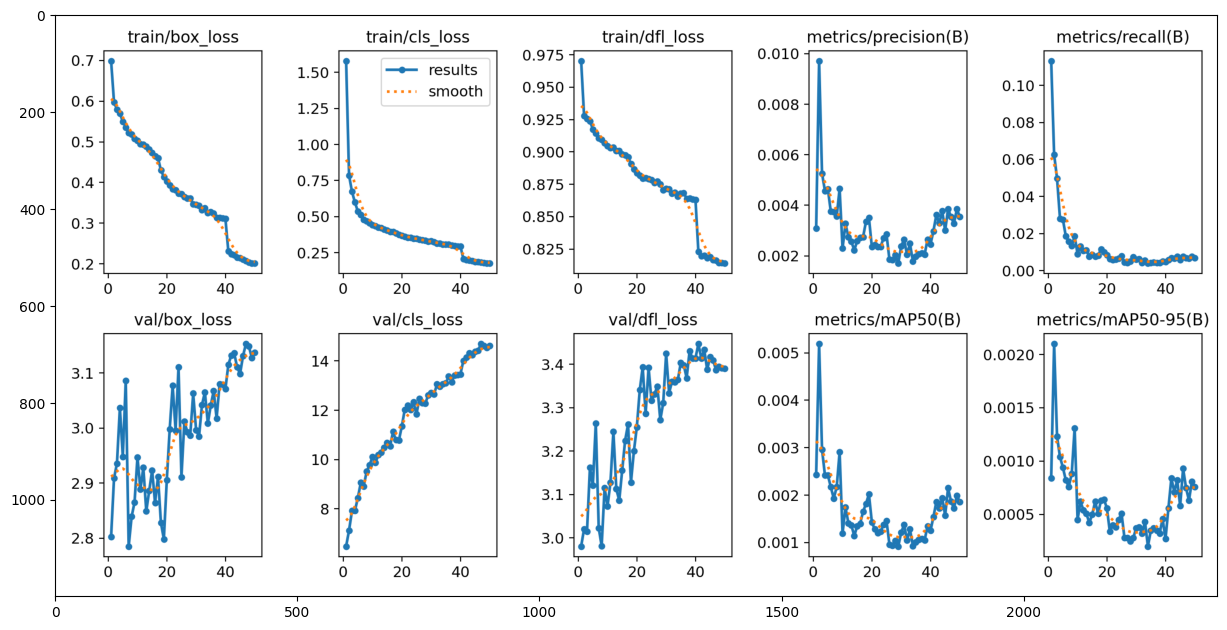

In [51]:
import matplotlib.pyplot as plt

results_img_path = '/content/runs/detect/train/results.png'

# Load the image using imread
img = plt.imread(results_img_path)
# set image size
plt.figure(figsize=(15, 15))
# Display the image using imshow
plt.imshow(img)
plt.show()

In [52]:
results = model.val()

# You can print the whole thing
print(results)



Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.35it/s]


                   all       1000       4323     0.0255      0.882      0.084     0.0616
               nothing       1000       1000      0.108      0.873      0.354      0.176
            helicopter        841        841     0.0592      0.998      0.183      0.164
              hospital        248        281    0.00972      0.623     0.0156     0.0138
              mountain        243        272    0.00552      0.522    0.00536    0.00419
                 skull        258        284     0.0119      0.789     0.0181      0.015
            skyscraper        242        280     0.0225      0.986     0.0638     0.0553
               tractor        256        282     0.0189      0.996     0.0774     0.0682
        traffic_lights        234        263     0.0122          1     0.0674     0.0607
                  vans        236        263     0.0114      0.996     0.0569     0.0502
                 trees        251        285     0.0132      0.982     0.0563     0.0488
                 clou

In [54]:
# These are common keys; exact content can vary by task (detect/segment/etc)
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"Number of classes: {results.box.nc}")
print(f"Per-class mAP: {results.box.maps}")  # List of mAP50-95 for each class


mAP50-95: 0.0616
mAP50: 0.0840
Number of classes: 13
Per-class mAP: [    0.17594     0.16402    0.013832   0.0041883    0.015046    0.055319    0.068175    0.060717    0.050182    0.048844    0.021752    0.061638    0.061638]


In [71]:
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")

Recall: 0.8817
Precision: 0.0255
mAP50-95: 0.0616
mAP50: 0.0840


In [32]:
model = YOLO('/content/runs/detect/train/weights/best.pt')

In [34]:
oldModel = YOLO('yolov8n.pt')
oldModel.load('/content/drive/MyDrive/Capstone/yolov8_model')

Transferred 58/355 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [49]:
results = oldModel.val(data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml")
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"Number of classes: {results.box.nc}")

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:35<00:00,  1.80it/s]


                   all       1000       4323   1.11e-05   0.000319   5.57e-06   5.57e-07
                person       1000       1000          0          0          0          0
               bicycle        841        841          0          0          0          0
                   car        248        281          0          0          0          0
            motorcycle        243        272          0          0          0          0
              airplane        258        284          0          0          0          0
                   bus        242        280          0          0          0          0
                 train        256        282          0          0          0          0
                 truck        234        263          0          0          0          0
                  boat        236        263          0          0          0          0
         traffic light        251        285   0.000122    0.00351   6.13e-05   6.13e-06
          fire hydran

In [48]:
results = model.val(data='/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml')
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"Number of classes: {results.box.nc}")

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:06<00:00, 164.58it/s]


val: New cache created: /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:07<00:00,  8.73it/s]


                   all       1000       4323     0.0502       0.56     0.0471     0.0421
               nothing       1000       1000     0.0833      0.008     0.0421     0.0221
            helicopter        841        841      0.123      0.831      0.137      0.125
              hospital        248        281     0.0403      0.587     0.0323     0.0301
              mountain        243        272    0.00627     0.0772    0.00338    0.00318
                 skull        258        284     0.0132      0.173    0.00779    0.00692
            skyscraper        242        280     0.0514      0.964     0.0552      0.052
               tractor        256        282     0.0394      0.564     0.0309      0.028
        traffic_lights        234        263     0.0409       0.76     0.0368     0.0341
                  vans        236        263     0.0538      0.802     0.0579     0.0537
                 trees        251        285      0.058      0.954     0.0845     0.0786
                 clou


image 1/1 /content/drive/MyDrive/Capstone/pen_test.png: 640x640 2 helicopters, 1 hospital, 3 mountains, 1 skull, 1 fire_truck, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Bounding Box: tensor([285.8315, 264.2971, 378.5912, 353.5399], device='cuda:0') Confidence: tensor([0.9661], device='cuda:0')
Bounding Box: tensor([414.8285,  93.2181, 639.6420, 236.8778], device='cuda:0') Confidence: tensor([0.9560], device='cuda:0')
Bounding Box: tensor([308.3801, 380.4312, 382.1774, 465.6902], device='cuda:0') Confidence: tensor([0.9492], device='cuda:0')
Bounding Box: tensor([295.0416, 191.5587, 383.3970, 255.2528], device='cuda:0') Confidence: tensor([0.9425], device='cuda:0')
Bounding Box: tensor([156.3053, 270.9538, 255.2254, 355.7418], device='cuda:0') Confidence: tensor([0.9411], device='cuda:0')
Bounding Box: tensor([438.9529, 362.8804, 571.3335, 482.6048], device='cuda:0') Confidence: tensor([0.9256], device='cuda:0')
Bounding Box

array([[[246, 242, 245],
        [249, 245, 248],
        [247, 242, 245],
        ...,
        [247, 240, 245],
        [250, 246, 249],
        [245, 238, 243]],

       [[242, 238, 241],
        [248, 244, 246],
        [244, 240, 242],
        ...,
        [247, 240, 245],
        [242, 235, 240],
        [244, 238, 242]],

       [[245, 241, 243],
        [241, 236, 239],
        [248, 244, 247],
        ...,
        [244, 236, 241],
        [247, 240, 245],
        [244, 236, 241]],

       ...,

       [[231, 217, 218],
        [234, 220, 221],
        [233, 219, 220],
        ...,
        [241, 233, 238],
        [241, 232, 237],
        [238, 230, 235]],

       [[229, 215, 216],
        [225, 211, 212],
        [234, 220, 222],
        ...,
        [241, 232, 237],
        [239, 230, 236],
        [242, 234, 239]],

       [[231, 217, 218],
        [228, 214, 215],
        [233, 215, 217],
        ...,
        [240, 231, 236],
        [241, 232, 237],
        [241, 233, 238]]], dtype=uint8)
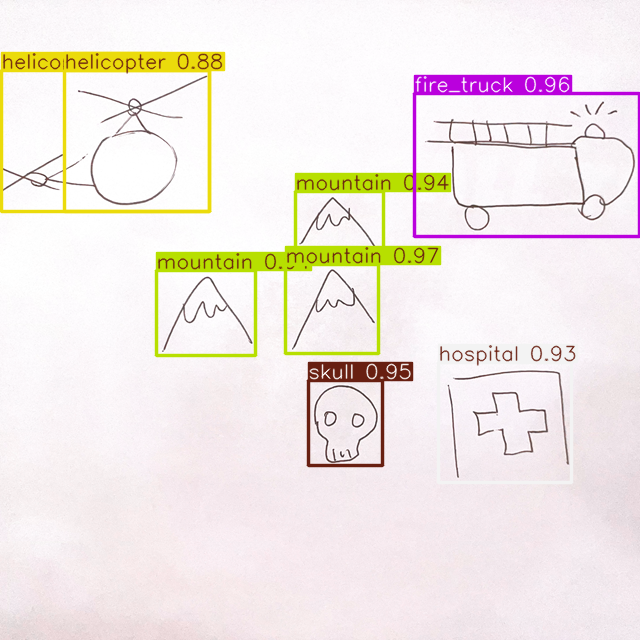

In [42]:
img_path = '/content/drive/MyDrive/Capstone/pen_test.png'
results = model(img_path)

# Process results
for r in results:
    boxes = r.boxes
    for box in boxes:
      print(f"Bounding Box: {box.xyxy[0]} Confidence: {box.conf}")

results[0].plot()


In [59]:
# prompt: copy content/runs folder to MyDrive/Capstone

import shutil
import os

# Define source and destination paths
source_path = '/content/runs'
destination_path = '/content/drive/MyDrive/Capstone'

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)


# Use shutil.copytree to copy the directory and its contents recursively
try:
    shutil.copytree(source_path, os.path.join(destination_path, 'runs'), dirs_exist_ok=True)
    print(f"Successfully copied '{source_path}' to '{destination_path}'")
except FileExistsError:
    print(f"Directory '{os.path.join(destination_path, 'runs')}' already exists.")
except Exception as e:
    print(f"An error occurred: {e}")


Successfully copied '/content/runs' to '/content/drive/MyDrive/Capstone'


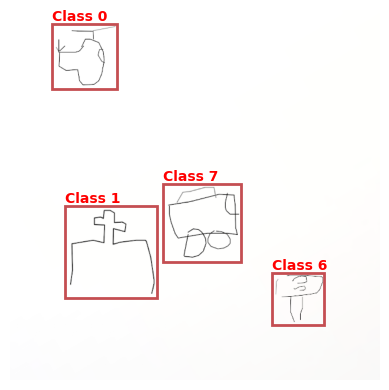

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Paths
validation_test_path = '/content/drive/MyDrive/Capstone/yolo_dataset/images/validation/image_1000.png'
validation_testlabel_path = '/content/drive/MyDrive/Capstone/yolo_dataset/labels/validation/image_1000.txt'

# Load image
image = plt.imread(validation_test_path)
h, w = image.shape[:2]

# Create plot
fig, ax = plt.subplots(1)
ax.imshow(image)

# Read label file and draw boxes
with open(validation_testlabel_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        cls_id = int(parts[0])
        xc = float(parts[1])
        yc = float(parts[2])
        bw = float(parts[3])
        bh = float(parts[4])

        # Convert normalized coords to pixel coords
        x = (xc - bw / 2) * w
        y = (yc - bh / 2) * h
        box_w = bw * w
        box_h = bh * h

        # Draw rectangle
        rect = patches.Rectangle((x, y), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Optionally label with class ID
        ax.text(x, y - 5, f"Class {cls_id}", color='red', fontsize=10, weight='bold')

plt.axis('off')
plt.show()




In [46]:
# prompt: iterate through the validation labels, and for each y box center, subtract it from 1 because the y axis was inverted

# Iterate through the validation labels and adjust the y-coordinates
base_dir = '/content/drive/MyDrive/Capstone/yolo_dataset'
valid_labels_dir = os.path.join(base_dir, 'labels', 'validation')

for filename in os.listdir(valid_labels_dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(valid_labels_dir, filename)
        with open(filepath, 'r') as f:
            lines = f.readlines()
        with open(filepath, 'w') as f:
            for line in lines:
                parts = line.strip().split()
                if parts:
                    cls_id = int(parts[0])
                    xc = float(parts[1])
                    yc = 1 - float(parts[2])  # Subtract y-center from 1
                    bw = float(parts[3])
                    bh = float(parts[4])
                    f.write(f"{cls_id} {xc} {yc} {bw} {bh}\n")


## Save Model

In [ ]:
model.save('/content/drive/MyDrive/Capstone/yolov8_model')

## Load Saved Model

In [31]:
model.load('/content/drive/MyDrive/Capstone/yolov8_model')

RuntimeError: Error(s) in loading state_dict for DetectionModel:
	While copying the parameter named "model.0.conv.weight", whose dimensions in the model are torch.Size([16, 3, 3, 3]) and whose dimensions in the checkpoint are torch.Size([16, 3, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.0.conv.bias", whose dimensions in the model are torch.Size([16]) and whose dimensions in the checkpoint are torch.Size([16]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.1.conv.weight", whose dimensions in the model are torch.Size([32, 16, 3, 3]) and whose dimensions in the checkpoint are torch.Size([32, 16, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.1.conv.bias", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([32]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.2.cv1.conv.weight", whose dimensions in the model are torch.Size([32, 32, 1, 1]) and whose dimensions in the checkpoint are torch.Size([32, 32, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.2.cv1.conv.bias", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([32]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.2.cv2.conv.weight", whose dimensions in the model are torch.Size([32, 48, 1, 1]) and whose dimensions in the checkpoint are torch.Size([32, 48, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.2.cv2.conv.bias", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([32]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.2.m.0.cv1.conv.weight", whose dimensions in the model are torch.Size([16, 16, 3, 3]) and whose dimensions in the checkpoint are torch.Size([16, 16, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.2.m.0.cv1.conv.bias", whose dimensions in the model are torch.Size([16]) and whose dimensions in the checkpoint are torch.Size([16]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.2.m.0.cv2.conv.weight", whose dimensions in the model are torch.Size([16, 16, 3, 3]) and whose dimensions in the checkpoint are torch.Size([16, 16, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.2.m.0.cv2.conv.bias", whose dimensions in the model are torch.Size([16]) and whose dimensions in the checkpoint are torch.Size([16]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.3.conv.weight", whose dimensions in the model are torch.Size([64, 32, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 32, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.3.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.cv1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 1, 1]) and whose dimensions in the checkpoint are torch.Size([64, 64, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.cv1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.cv2.conv.weight", whose dimensions in the model are torch.Size([64, 128, 1, 1]) and whose dimensions in the checkpoint are torch.Size([64, 128, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.cv2.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.m.0.cv1.conv.weight", whose dimensions in the model are torch.Size([32, 32, 3, 3]) and whose dimensions in the checkpoint are torch.Size([32, 32, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.m.0.cv1.conv.bias", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([32]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.m.0.cv2.conv.weight", whose dimensions in the model are torch.Size([32, 32, 3, 3]) and whose dimensions in the checkpoint are torch.Size([32, 32, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.m.0.cv2.conv.bias", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([32]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.m.1.cv1.conv.weight", whose dimensions in the model are torch.Size([32, 32, 3, 3]) and whose dimensions in the checkpoint are torch.Size([32, 32, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.m.1.cv1.conv.bias", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([32]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.m.1.cv2.conv.weight", whose dimensions in the model are torch.Size([32, 32, 3, 3]) and whose dimensions in the checkpoint are torch.Size([32, 32, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.4.m.1.cv2.conv.bias", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([32]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.5.conv.weight", whose dimensions in the model are torch.Size([128, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([128, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.5.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.cv1.conv.weight", whose dimensions in the model are torch.Size([128, 128, 1, 1]) and whose dimensions in the checkpoint are torch.Size([128, 128, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.cv1.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.cv2.conv.weight", whose dimensions in the model are torch.Size([128, 256, 1, 1]) and whose dimensions in the checkpoint are torch.Size([128, 256, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.cv2.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.m.0.cv1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.m.0.cv1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.m.0.cv2.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.m.0.cv2.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.m.1.cv1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.m.1.cv1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.m.1.cv2.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.6.m.1.cv2.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.7.conv.weight", whose dimensions in the model are torch.Size([256, 128, 3, 3]) and whose dimensions in the checkpoint are torch.Size([256, 128, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.7.conv.bias", whose dimensions in the model are torch.Size([256]) and whose dimensions in the checkpoint are torch.Size([256]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.8.cv1.conv.weight", whose dimensions in the model are torch.Size([256, 256, 1, 1]) and whose dimensions in the checkpoint are torch.Size([256, 256, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.8.cv1.conv.bias", whose dimensions in the model are torch.Size([256]) and whose dimensions in the checkpoint are torch.Size([256]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.8.cv2.conv.weight", whose dimensions in the model are torch.Size([256, 384, 1, 1]) and whose dimensions in the checkpoint are torch.Size([256, 384, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.8.cv2.conv.bias", whose dimensions in the model are torch.Size([256]) and whose dimensions in the checkpoint are torch.Size([256]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.8.m.0.cv1.conv.weight", whose dimensions in the model are torch.Size([128, 128, 3, 3]) and whose dimensions in the checkpoint are torch.Size([128, 128, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.8.m.0.cv1.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.8.m.0.cv2.conv.weight", whose dimensions in the model are torch.Size([128, 128, 3, 3]) and whose dimensions in the checkpoint are torch.Size([128, 128, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.8.m.0.cv2.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.9.cv1.conv.weight", whose dimensions in the model are torch.Size([128, 256, 1, 1]) and whose dimensions in the checkpoint are torch.Size([128, 256, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.9.cv1.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.9.cv2.conv.weight", whose dimensions in the model are torch.Size([256, 512, 1, 1]) and whose dimensions in the checkpoint are torch.Size([256, 512, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.9.cv2.conv.bias", whose dimensions in the model are torch.Size([256]) and whose dimensions in the checkpoint are torch.Size([256]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.12.cv1.conv.weight", whose dimensions in the model are torch.Size([128, 384, 1, 1]) and whose dimensions in the checkpoint are torch.Size([128, 384, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.12.cv1.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.12.cv2.conv.weight", whose dimensions in the model are torch.Size([128, 192, 1, 1]) and whose dimensions in the checkpoint are torch.Size([128, 192, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.12.cv2.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.12.m.0.cv1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.12.m.0.cv1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.12.m.0.cv2.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.12.m.0.cv2.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.15.cv1.conv.weight", whose dimensions in the model are torch.Size([64, 192, 1, 1]) and whose dimensions in the checkpoint are torch.Size([64, 192, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.15.cv1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.15.cv2.conv.weight", whose dimensions in the model are torch.Size([64, 96, 1, 1]) and whose dimensions in the checkpoint are torch.Size([64, 96, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.15.cv2.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.15.m.0.cv1.conv.weight", whose dimensions in the model are torch.Size([32, 32, 3, 3]) and whose dimensions in the checkpoint are torch.Size([32, 32, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.15.m.0.cv1.conv.bias", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([32]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.15.m.0.cv2.conv.weight", whose dimensions in the model are torch.Size([32, 32, 3, 3]) and whose dimensions in the checkpoint are torch.Size([32, 32, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.15.m.0.cv2.conv.bias", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([32]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.16.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.16.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.18.cv1.conv.weight", whose dimensions in the model are torch.Size([128, 192, 1, 1]) and whose dimensions in the checkpoint are torch.Size([128, 192, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.18.cv1.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.18.cv2.conv.weight", whose dimensions in the model are torch.Size([128, 192, 1, 1]) and whose dimensions in the checkpoint are torch.Size([128, 192, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.18.cv2.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.18.m.0.cv1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.18.m.0.cv1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.18.m.0.cv2.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.18.m.0.cv2.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.19.conv.weight", whose dimensions in the model are torch.Size([128, 128, 3, 3]) and whose dimensions in the checkpoint are torch.Size([128, 128, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.19.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.21.cv1.conv.weight", whose dimensions in the model are torch.Size([256, 384, 1, 1]) and whose dimensions in the checkpoint are torch.Size([256, 384, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.21.cv1.conv.bias", whose dimensions in the model are torch.Size([256]) and whose dimensions in the checkpoint are torch.Size([256]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.21.cv2.conv.weight", whose dimensions in the model are torch.Size([256, 384, 1, 1]) and whose dimensions in the checkpoint are torch.Size([256, 384, 1, 1]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.21.cv2.conv.bias", whose dimensions in the model are torch.Size([256]) and whose dimensions in the checkpoint are torch.Size([256]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.21.m.0.cv1.conv.weight", whose dimensions in the model are torch.Size([128, 128, 3, 3]) and whose dimensions in the checkpoint are torch.Size([128, 128, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.21.m.0.cv1.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.21.m.0.cv2.conv.weight", whose dimensions in the model are torch.Size([128, 128, 3, 3]) and whose dimensions in the checkpoint are torch.Size([128, 128, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.21.m.0.cv2.conv.bias", whose dimensions in the model are torch.Size([128]) and whose dimensions in the checkpoint are torch.Size([128]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.0.0.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.0.0.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.0.1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.0.1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.1.0.conv.weight", whose dimensions in the model are torch.Size([64, 128, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 128, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.1.0.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.1.1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.1.1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.2.0.conv.weight", whose dimensions in the model are torch.Size([64, 256, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 256, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.2.0.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.2.1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv2.2.1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.0.0.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.0.0.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.0.1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.0.1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.1.0.conv.weight", whose dimensions in the model are torch.Size([64, 128, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 128, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.1.0.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.1.1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.1.1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.2.0.conv.weight", whose dimensions in the model are torch.Size([64, 256, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 256, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.2.0.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.2.1.conv.weight", whose dimensions in the model are torch.Size([64, 64, 3, 3]) and whose dimensions in the checkpoint are torch.Size([64, 64, 3, 3]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).
	While copying the parameter named "model.22.cv3.2.1.conv.bias", whose dimensions in the model are torch.Size([64]) and whose dimensions in the checkpoint are torch.Size([64]), an exception occurred : ('Inplace update to inference tensor outside InferenceMode is not allowed.You can make a clone to get a normal tensor before doing inplace update.See https://github.com/pytorch/rfcs/pull/17 for more details.',).

## Export Model

In [72]:
model.export(format='onnx')

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train5/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 17, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 193.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 292.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 168.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 220.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 287.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 13.1s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: s

'runs/detect/train5/weights/best.onnx'

## Hyperparameter Tuning

In [80]:
import pandas as pd

# Path to the CSV from your training run
csv_path = "/content/runs/detect/train5/results.csv"

# Load and clean the data
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()  # Remove weird whitespace

# Find the epoch with the best mAP50 (or mAP50-95 if you prefer)
best_epoch = df['map50'].idxmax()
best_map = df['map50'].max()

print(f"Best mAP50 of {best_map:.4f} occurred at epoch {best_epoch}")


KeyError: 'map50'

In [ ]:
search_space = {
    "lr0": (1e-5, 1e-3, 1e-1),
    "degrees": (0.0, 45.0),
    "lrf": (1e-6, 1e-4, 1e-2),
    "momentum": (0.5, 0.95),
    "weight_decay": (1e-5, 1e-1),
    "warmup_epochs": (0, 3),
    "warmup_momentum": (0.5, 0.95),
    "warmup_bias_lr": (1e-6, 1e-4, 1e-2),
    "cls": (0.2, 0.6, 2.0, 4.0)
}

# Tune hyperparameters on COCO8 for 30 epochs
model.tune(
    data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml",
    epochs=20,
    iterations=300,
    optimizer="AdamW",
    space=search_space,
    plots=False,
    save=False,
    val=False,
)

Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/train53'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/300 with hyperparameters: {'lr0': 0.001, 'degrees': 0.0, 'lrf': 0.0001, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.0, 'cls': 0.5}
